In [ ]:
from torchvision.datasets import CIFAR100
import numpy as np
from PIL import Image


class iCIFAR100(CIFAR100):
    def __init__(self,root,
                 train=True,
                 transform=None,
                 target_transform=None,
                 test_transform=None,
                 target_test_transform=None,
                 download=False):
        super(iCIFAR100,self).__init__(root,
                                       train=train,
                                       transform=transform,
                                       target_transform=target_transform,
                                       download=download)

        self.target_test_transform=target_test_transform
        self.test_transform=test_transform
        self.TrainData = []
        self.TrainLabels = []
        self.TestData = []
        self.TestLabels = []

    def concatenate(self,datas,labels):
        con_data=datas[0]
        con_label=labels[0]
        for i in range(1,len(datas)):
            con_data=np.concatenate((con_data,datas[i]),axis=0)
            con_label=np.concatenate((con_label,labels[i]),axis=0)
        return con_data,con_label

    def getTestData(self, classes):
        datas,labels=[],[]
        for label in range(classes[0], classes[1]):
            data = self.data[np.array(self.targets) == label]
            datas.append(data)
            labels.append(np.full((data.shape[0]), label))
        datas,labels=self.concatenate(datas,labels)
        self.TestData=datas if self.TestData==[] else np.concatenate((self.TestData,datas),axis=0)
        self.TestLabels=labels if self.TestLabels==[] else np.concatenate((self.TestLabels,labels),axis=0)
        print("the size of test set is %s"%(str(self.TestData.shape)))
        print("the size of test label is %s"%str(self.TestLabels.shape))


    def getTrainData(self,classes,exemplar_set):

        datas,labels=[],[]
        if len(exemplar_set)!=0:
            datas=[exemplar for exemplar in exemplar_set ]
            length=len(datas[0])
            labels=[np.full((length),label) for label in range(len(exemplar_set))]

        for label in range(classes[0],classes[1]):
            data=self.data[np.array(self.targets)==label]
            datas.append(data)
            labels.append(np.full((data.shape[0]),label))
        self.TrainData,self.TrainLabels=self.concatenate(datas,labels)
        print("the size of train set is %s"%(str(self.TrainData.shape)))
        print("the size of train label is %s"%str(self.TrainLabels.shape))

    def getTestDataCurrentClasses(self, classes):
        datas,labels=[],[]
        for label in range(classes[0],classes[1]):
            data = self.data[np.array(self.targets) == label]
            datas.append(data)
            labels.append(np.full((data.shape[0]), label))
        datas,labels=self.concatenate(datas,labels)
        self.TestData=datas 
        self.TestLabels=labels 
        print("the size of test current classses set is %s"%(str(self.TestData.shape)))
        print("the size of test label current classes is %s"%str(self.TestLabels.shape))

    def getTrainItem(self,index):
        img, target = Image.fromarray(self.TrainData[index]), self.TrainLabels[index]

        if self.transform:
            img=self.transform(img)

        if self.target_transform:
            target=self.target_transform(target)

        return index,img,target

    def getTestItem(self,index):
        img, target = Image.fromarray(self.TestData[index]), self.TestLabels[index]

        if self.test_transform:
            img=self.test_transform(img)

        if self.target_test_transform:
            target=self.target_test_transform(target)

        return index, img, target

    def __getitem__(self, index):
        if self.TrainData!=[]:
            return self.getTrainItem(index)
        elif self.TestData!=[]:
            return self.getTestItem(index)


    def __len__(self):
        if self.TrainData!=[]:
            return len(self.TrainData)
        elif self.TestData!=[]:
            return len(self.TestData)

    def get_image_class(self,label):
        return self.data[np.array(self.targets)==label]

In [ ]:
import torch
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo
import torch
import math
import torch.nn as nn
import torch.nn.functional as F

__all__ = ['ResNet', 'resnet18_cbam', 'resnet34_cbam', 'resnet50_cbam', 'resnet101_cbam',
           'resnet152_cbam']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.sequential = nn.Sequential(
                   
        Flatten(),
        nn.Linear(in_planes, in_planes // 16, bias=False),
        nn.ReLU(),
        nn.Linear(in_planes // 16, in_planes,  bias=False),
        )
    def forward(self, x):
        avg_out = self.sequential(self.avg_pool(x))
        max_out = self.sequential(self.max_pool(x))
        out = avg_out + max_out
        return F.sigmoid( out ).unsqueeze(2).unsqueeze(3).expand_as(x)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        #print('输入的shape为:'+str(x.shape))
        avg_out = torch.mean(x, dim=1, keepdim=True)
        #print('avg_out的shape为:' + str(avg_out.shape))
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        #print('max_out的shape为:' + str(max_out.shape))
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

       # self.ca = ChannelAttention(planes)
       # self.sa = SpatialAttention()

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        
       # out = self.ca(out) * out
       # out = self.sa(out) * out

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)

        self.ca = ChannelAttention(planes * 4)
        self.sa = SpatialAttention()

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

       # out = self.ca(out) * out
        #out = self.sa(out) * out

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=100):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.feature = nn.AvgPool2d(4, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.feature(x)
        x = x.view(x.size(0), -1)
        #y=torch.norm(x,p=2,dim=1,keepdim=True)
        #x/=y
        #x = self.fc(x)

        return x


def resnet18_cbam(pretrained=False, **kwargs):
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    return model



In [ ]:
class CosineLinear(nn.Module):	
    def __init__(self, in_features, out_features, sigma=True):	
        super(CosineLinear, self).__init__()	
        self.in_features = in_features	
        self.out_features = out_features	
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))	
        if sigma:	
            self.sigma = nn.Parameter(torch.Tensor(1))	
        else:	
            self.register_parameter('sigma', None)	
        print(self.sigma)
        self.reset_parameters()	

    def reset_parameters(self):	
        stdv = 1. / math.sqrt(self.weight.size(1))	
        self.weight.data.uniform_(-stdv, stdv)
        if self.sigma is not None:	
            self.sigma.data.fill_(1) #for initializaiton of sigma	

    def forward(self, input):	
        out = F.linear(F.normalize(input, p=2,dim=1), F.normalize(self.weight, p=2, dim=1))	
        if self.sigma is not None:	
            out = self.sigma * out	
        return out


In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, last=False):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

       # self.ca = ChannelAttention(planes)
       # self.sa = SpatialAttention()

        self.downsample = downsample
        self.stride = stride
        self.last=last

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        
       # out = self.ca(out) * out
       # out = self.sa(out) * out

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        if not self.last:
          out = self.relu(out)

        return out




class ResNetCosine(nn.Module):

  

    def __init__(self, block, layers, num_classes=100):
        self.inplanes = 64
        super(ResNetCosine, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, last_phase=True)
        self.feature = nn.AvgPool2d(4, stride=1)
        self.fc = CosineLinear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1, last_phase=False):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        if last_phase:
          for i in range(1, blocks-1):
            layers.append(block(self.inplanes, planes, last=True))
        else:
          for i in range(1, blocks):
                layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.feature(x)
        x = x.view(x.size(0), -1)
        #x = torch.nn.functional.normalize(x, p=2, dim=1)
        #y=torch.norm(x,p=2,dim=1,keepdim=True)
        #x/=y
        #x = self.fc(x)

        return x

def resnet18_cbamCosine(pretrained=False, **kwargs):
   
    model = ResNetCosine(BasicBlock, [2, 2, 2, 2], **kwargs)
    return model

In [ ]:
import torch.nn as nn

class network(nn.Module):

    def __init__(self, numclass, feature_extractor):
        super(network, self).__init__()
        self.feature = feature_extractor
        self.fc = nn.Linear(feature_extractor.fc.in_features, numclass, bias=True)

    def forward(self, input):
        x = self.feature(input)
        x = self.fc(x)
        return x

    def Incremental_learning(self, numclass):
        weight = self.fc.weight.data
        bias = self.fc.bias.data
        in_feature = self.fc.in_features
        out_feature = self.fc.out_features

        self.fc = nn.Linear(in_feature, numclass, bias=True)
        self.fc.weight.data[:out_feature] = weight
        self.fc.bias.data[:out_feature] = bias

    def feature_extractor(self,inputs):
        return self.feature(inputs)

In [ ]:
from torchvision.datasets import CIFAR100
import numpy as np
from PIL import Image
import os
import logging
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.datasets import CIFAR100
from PIL import Image
import sys
import copy
from PIL import Image
from collections import defaultdict
from itertools import groupby
import torchvision.models as models
from sklearn.model_selection import StratifiedShuffleSplit
import math
from torch.nn import functional as F
device = 'cuda'
from torch.nn import BCEWithLogitsLoss 
from sklearn.metrics import confusion_matrix
class Finetuning:
      def __init__(self,numclass,feature_extractor,batch_size,task_size,memory_size,epochs,learning_rate):
        super(Finetuning, self).__init__()
        self.epochs=epochs
        self.learning_rate=learning_rate
        self.net = network(100, feature_extractor) # 100
        self.numclass = numclass
        self.transform = transforms.Compose([
                                             transforms.ToTensor(),
                                             transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])
        self.old_model = None

        self.train_transform = transforms.Compose([
                                                  transforms.RandomCrop(32, padding=4),
                                                  transforms.RandomHorizontalFlip(p=0.5),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])
        
        self.test_transform = transforms.Compose([
                                                  transforms.ToTensor(),
                                                  transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])
        self.test_current_transform = transforms.Compose([
                                                  transforms.ToTensor(),
                                                  transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])
        
        
        
        self.train_dataset = iCIFAR100('dataset', transform=self.train_transform, download=True)
        self.test_dataset = iCIFAR100('dataset', test_transform=self.test_transform, train=False, download=True)
        self.test_current_classes = iCIFAR100('dataset', test_transform=self.test_transform,train = False,download=True)

        rng = np.random.default_rng()
        h = rng.choice(100, size=100, replace= False)
        dic = {i:h[i] for i in range(100)}

        self.batchsize = batch_size
        self.memory_size=memory_size
        self.task_size=task_size

        self.train_dataset.targets = [ dic[self.train_dataset.targets[i]] for i in range(len(self.train_dataset.targets))]
        self.test_dataset.targets = [ dic[self.test_dataset.targets[i]] for i in range(len(self.test_dataset.targets))]
        self.test_current_classes.targets = [ dic[self.test_current_classes.targets[i]] for i in range(len(self.test_current_classes.targets))]

        self.batchsize = batch_size
        self.memory_size=memory_size
        self.task_size=task_size

        self.train_loader=None
        self.test_loader=None
        self.test_current_classes_loader = None
      

      def _get_train_and_test_dataloader(self, classes):
        self.test_current_classes.getTestDataCurrentClasses(classes)
        self.train_dataset.getTrainData(classes, [])
        self.test_dataset.getTestData(classes)
        train_loader = DataLoader(dataset=self.train_dataset,
                                  shuffle=True,
                                  batch_size=self.batchsize)

        test_loader = DataLoader(dataset=self.test_dataset,
                                 shuffle=True,
                                 batch_size=self.batchsize)
        
        test_current_classes_loader = DataLoader(dataset=self.test_current_classes,
                                 shuffle=True,
                                 batch_size=self.batchsize)

        return train_loader, test_loader,test_current_classes_loader

      def train(self):
        
        classes=[self.numclass-self.task_size,self.numclass]
        self.train_loader,self.test_loader,self.test_current_classes_loader=self._get_train_and_test_dataloader(classes)
        self.net.train()
        self.net.to(device)

        opt = optim.SGD(self.net.parameters(), lr=self.learning_rate, momentum=0.9, weight_decay=0.00001)
        for epoch in range(self.epochs):
            if epoch == 48:
                for p in opt.param_groups:
                  p['lr'] =self.learning_rate/ 5
                print("change learning rate:%.3f" % (self.learning_rate / 5))
            if epoch == 62:
                for p in opt.param_groups:
                  p['lr'] =self.learning_rate/ 25
                print("change learning rate:%.3f" % (self.learning_rate / 25))
            for step, (indexs, images, target) in enumerate(self.train_loader):
                # load train images and target into model
                images, target = images.to(device), target.to(device)
                #compute bce loss
                loss_value = self._compute_loss(indexs, images, target,"BCE_Logits") #passa parametro per cambiare il loss
                #zeroes grad structures 
                opt.zero_grad()
                #calculate 
                loss_value.backward()
                opt.step()
                print('epoch:%d,step:%d,loss:%.3f' % (epoch, step, loss_value.item()))
            
            accuracy_el = self._test(self.test_loader)

            print('epoch:%d,accuracy:%.3f' % (epoch,accuracy_el))

            # calculate accuracy on validation set
        accuracy_el = self._test(self.test_loader)
        accuracy_c = self._test(self.test_current_classes_loader)


        print('epoch:%d,test_accuracy:%.3f' % (epoch, accuracy_el))
        self.numclass+=self.task_size  
        return [accuracy_el,accuracy_c]

      def _test(self, testloader):
        self.net.eval()
        correct, total = 0, 0
        for setp, (indexs, imgs, labels) in enumerate(testloader):
            imgs, labels = imgs.to(device), labels.to(device)
            with torch.no_grad():
                outputs = self.net(imgs) 
            predicts = torch.max(outputs, dim=1)[1] 
            correct += (predicts.cpu() == labels.cpu()).sum()
            total += len(labels)
        accuracy = 100 * correct / total
        self.net.train()
        return accuracy

      def _val(self, testloader): 
        self.net.eval()
        correct, total = 0, 0
        for setp, (indexs, imgs, labels) in enumerate(testloader):
            imgs, labels = imgs.to(device), labels.to(device)
            with torch.no_grad():
                outputs = self.net(imgs)
            predicts = torch.max(outputs, dim=1)[1]
            correct += (predicts.cpu() == labels.cpu()).sum()
            total += len(labels)
        accuracy = 100 * correct / total
        self.net.train()
        return accuracy

      def _compute_loss(self, indexs, imgs, target,loss):
        output=self.net(imgs)
        target = self.get_one_hot(target, 100)
        output, target = output.to(device), target.to(device)
        if loss == "BCE_Logits": criterion= BCEWithLogitsLoss()
        if loss == "hinge" : criterion= torch.nn.HingeEmbeddingLoss(margin=1.0, 
                                                 size_average=None, reduce=None, reduction='mean')
        if loss == "MSE" : criterion = torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean')
        if loss == "Cross" : criterion = torch.nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')
        if self.old_model == None:
            return criterion(output, target)
        else:
            old_target=torch.sigmoid(self.old_model(imgs))
            old_task_size = old_target.shape[1]
            target[..., :old_task_size] = old_target
            return criterion(output, target)
    
    
      def get_one_hot(self,target,num_class):
        one_hot=torch.zeros(target.shape[0],num_class).to(device)
        one_hot=one_hot.scatter(dim=1,index=target.long().view(-1,1),value=1.)
        return one_hot

     
      def getNet(self):
        return copy.deepcopy(self.net)

      def getTestLoader(self):
        return self.test_loader





In [ ]:
class jointTraining:
  def __init__(self,numclass,feature_extractor,batch_size,task_size,memory_size,epochs,learning_rate):
        super(jointTraining, self).__init__()
        self.epochs=epochs
        self.learning_rate=learning_rate
        self.net = network(100, feature_extractor) # 100
        self.numclass = numclass
        self.transform = transforms.Compose([
                                             transforms.ToTensor(),
                                             transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])
        self.old_model = None

        self.train_transform = transforms.Compose([
                                                  transforms.RandomCrop(32, padding=4),
                                                  transforms.RandomHorizontalFlip(p=0.5),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])
        
        self.test_transform = transforms.Compose([
                                                  transforms.ToTensor(),
                                                  transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])
        
        self.classify_transform=transforms.Compose([transforms.RandomHorizontalFlip(p=1.),
                                                    
                                                    transforms.ToTensor(),
                                                    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])
        
        self.train_dataset = iCIFAR100('dataset', transform=self.train_transform, download=True)
        self.test_dataset = iCIFAR100('dataset', test_transform=self.test_transform, train=False, download=True)
        

        self.batchsize = batch_size
        self.memory_size=memory_size
        self.task_size=task_size

        self.train_loader=None
        self.test_loader=None

  def _get_train_and_test_dataloader(self, classes):
        self.train_dataset.getTrainData(classes, [])
        self.test_dataset.getTestData(classes)
        train_loader = DataLoader(dataset=self.train_dataset,
                                  shuffle=True,
                                  batch_size=self.batchsize,
                                  num_workers=4)

        test_loader = DataLoader(dataset=self.test_dataset,
                                 shuffle=True,
                                 batch_size=self.batchsize,
                                 num_workers=4)
        return train_loader, test_loader

  def train(self):
        
        classes=[0,self.numclass]
        self.train_loader,self.test_loader=self._get_train_and_test_dataloader(classes)
        self.net.train()
        self.net.to(device)

        opt = optim.SGD(self.net.parameters(), lr=self.learning_rate, momentum=0.9, weight_decay=0.00001)
        for epoch in range(self.epochs):
            if epoch == 48:
                for p in opt.param_groups:
                  p['lr'] =self.learning_rate/ 5
                print("change learning rate:%.3f" % (self.learning_rate / 5))
            if epoch == 62:
                for p in opt.param_groups:
                  p['lr'] =self.learning_rate/ 25
                print("change learning rate:%.3f" % (self.learning_rate / 25))
            for step, (indexs, images, target) in enumerate(self.train_loader):
                # load train images and target into model
                images, target = images.to(device), target.to(device)
                #compute bce loss
                loss_value = self._compute_loss(indexs, images, target,"BCE_Logits") #passa parametro per cambiare il loss
                #zeroes grad structures 
                opt.zero_grad()
                #calculate 
                loss_value.backward()
                opt.step()
                print('epoch:%d,step:%d,loss:%.3f' % (epoch, step, loss_value.item()))
            accuracy_el = self._test(self.test_loader)
            print('epoch:%d,accuracy:%.3f' % (epoch,accuracy_el))

            # calculate accuracy on validation set
        accuracy_el = self._test(self.test_loader)

  def _test(self, testloader):
        self.net.eval()
        correct, total = 0, 0
        for setp, (indexs, imgs, labels) in enumerate(testloader):
            imgs, labels = imgs.to(device), labels.to(device)
            with torch.no_grad():
                outputs = self.net(imgs) 
            predicts = torch.max(outputs, dim=1)[1] 
            correct += (predicts.cpu() == labels.cpu()).sum()
            total += len(labels)
        accuracy = 100 * correct / total
        self.net.train()
        return accuracy

        print('epoch:%d,test_accuracy:%.3f' % (epoch, accuracy_el))
        self.numclass+=self.task_size  
        return accuracy_el
        
  def _compute_loss(self, indexs, imgs, target,loss):
        output=self.net(imgs)
        target = self.get_one_hot(target, 100)
        output, target = output.to(device), target.to(device)
        if loss == "BCE_Logits": criterion= BCEWithLogitsLoss()
        if loss == "hinge" : criterion= torch.nn.HingeEmbeddingLoss(margin=1.0, 
                                                 size_average=None, reduce=None, reduction='mean')
        if loss == "MSE" : criterion = torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean')
        if loss == "Cross" : criterion = torch.nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')
        if self.old_model == None:
            return criterion(output, target)
        else:
            old_target=torch.sigmoid(self.old_model(imgs))
            old_task_size = old_target.shape[1]
            target[..., :old_task_size] = old_target
            return criterion(output, target)
    
    
  def get_one_hot(self,target,num_class):
        one_hot=torch.zeros(target.shape[0],num_class).to(device)
        one_hot=one_hot.scatter(dim=1,index=target.long().view(-1,1),value=1.)
        return one_hot


In [ ]:

import torch.nn as nn
import torch
from torchvision import transforms
import numpy as np
from torch.nn import functional as F
from PIL import Image
import torch.optim as optim
import copy
from torch.utils.data import DataLoader

device = 'cuda'
def get_one_hot(target,num_class):
    one_hot=torch.zeros(target.shape[0],num_class).to(device)
    one_hot=one_hot.scatter(dim=1,index=target.long().view(-1,1),value=1.)
    return one_hot

class LWF:

    def __init__(self,numclass,feature_extractor,batch_size,task_size,memory_size,epochs,learning_rate):

        super(LWF, self).__init__()
        self.epochs=epochs
        self.learning_rate=learning_rate
        self.model = network(numclass,feature_extractor)
        self.exemplar_set = []
        self.class_mean_set = []
        self.numclass = numclass
        self.transform = transforms.Compose([#transforms.Resize(img_size),
                                             transforms.ToTensor(),
                                            transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])
        self.old_model = None

        self.train_transform = transforms.Compose([#transforms.Resize(img_size),
                                                  transforms.RandomCrop((32,32),padding=4),
                                                  transforms.RandomHorizontalFlip(p=0.5),
                                                  
                                                  transforms.ToTensor(),
                                                  transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])
        
        self.test_transform = transforms.Compose([#transforms.Resize(img_size),
                                                   transforms.ToTensor(),
                                                 transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])
        
        self.classify_transform=transforms.Compose([transforms.RandomHorizontalFlip(p=1.),
                                                    #transforms.Resize(img_size),
                                                    transforms.ToTensor(),
                                                   transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])
        
        self.train_dataset = iCIFAR100('dataset', transform=self.train_transform, download=True)
        self.test_dataset = iCIFAR100('dataset', test_transform=self.test_transform, train=False, download=True)
        self.test_current_classes = iCIFAR100('dataset', test_transform=self.test_transform,train = False, download=True)


        rng = np.random.default_rng()
        h = rng.choice(100, size=100, replace= False)
        dic = {i:h[i] for i in range(100)}
        self.batchsize = batch_size
        self.memory_size=memory_size
        self.task_size=task_size

        self.train_dataset.targets = [ dic[self.train_dataset.targets[i]] for i in range(len(self.train_dataset.targets))]
        self.test_dataset.targets = [ dic[self.test_dataset.targets[i]] for i in range(len(self.test_dataset.targets))]
        self.test_current_classes.targets = [ dic[self.test_current_classes.targets[i]] for i in range(len(self.test_current_classes.targets))]
        self.batchsize = batch_size
        self.memory_size=memory_size
        self.task_size=task_size

        self.train_loader=None
        self.test_loader=None
        self.test_current_classes_loader = None

    # get incremental train data
    # incremental        

    def _get_train_and_test_dataloader(self, classes):
        self.test_current_classes.getTestDataCurrentClasses(classes)
        self.train_dataset.getTrainData(classes, self.exemplar_set)
        self.test_dataset.getTestData(classes)
        train_loader = DataLoader(dataset=self.train_dataset,
                                  shuffle=True,
                                  batch_size=self.batchsize)

        test_loader = DataLoader(dataset=self.test_dataset,
                                 shuffle=True,
                                 batch_size=self.batchsize)
        
        test_current_classes_loader = DataLoader(dataset=self.test_current_classes,
                                 shuffle=True,
                                 batch_size=self.batchsize)

        return train_loader, test_loader,test_current_classes_loader
    
 
    # train model
    # compute loss
    # evaluate model
    def train(self):
        classes=[self.numclass-self.task_size,self.numclass]
        self.train_loader,self.test_loader, self.test_current_classes_loader=self._get_train_and_test_dataloader(classes)
        if self.numclass>self.task_size:
            self.model.Incremental_learning(self.numclass)
        self.model.train()
        self.model.to(device)
        accuracy = 0
        opt = optim.SGD(self.model.parameters(), lr=self.learning_rate, weight_decay=0.00001)
        for epoch in range(self.epochs):
            if epoch == 48:
                if self.numclass==self.task_size:
                     print(1)
                     opt = optim.SGD(self.model.parameters(), lr=self.learning_rate /5, weight_decay=0.00001)
                else:
                     for p in opt.param_groups:
                         p['lr'] =self.learning_rate/ 5
                     #opt = optim.SGD(self.model.parameters(), lr=self.learning_rate/ 5,weight_decay=0.00001,momentum=0.9,nesterov=True,)
                print("change learning rate:%.3f" % (self.learning_rate / 5))
            elif epoch == 62:
                if self.numclass>self.task_size:
                     for p in opt.param_groups:
                         p['lr'] =self.learning_rate/ 25
                     #opt = optim.SGD(self.model.parameters(), lr=self.learning_rate/ 25,weight_decay=0.00001,momentum=0.9,nesterov=True,)
                else:
                     opt = optim.SGD(self.model.parameters(), lr=self.learning_rate /25, weight_decay=0.00001)
                print("change learning rate:%.3f" % (self.learning_rate / 25))
            
            for step, (indexs, images, target) in enumerate(self.train_loader):
                images, target = images.to(device), target.to(device)
                #output = self.model(images)
                loss_value = self._compute_loss(indexs, images, target)
                opt.zero_grad()
                loss_value.backward()
                opt.step()
                print('epoch:%d,step:%d,loss:%.3f' % (epoch, step, loss_value.item()))
        accuracy = float(self._test(self.test_loader))
        acc_c = float(self._test(self.test_current_classes_loader))
        print('epoch:%d,accuracy:%.3f' % (epoch, accuracy))
        self.numclass+=self.task_size
        self.old_model=copy.deepcopy(self.model)
        self.old_model.to(device)
        self.old_model.eval()
        return [accuracy,acc_c]

    def _test(self, testloader):
        self.model.eval()
        correct, total = 0, 0
        for setp, (indexs, imgs, labels) in enumerate(testloader):
            imgs, labels = imgs.to(device), labels.to(device)
            with torch.no_grad():
                outputs = self.model(imgs) 
            predicts = torch.max(outputs, dim=1)[1] 
            correct += (predicts.cpu() == labels.cpu()).sum()
            total += len(labels)
        accuracy = 100 * correct / total
        self.model.train()
        return accuracy


    def _compute_loss(self, indexs, imgs, target):
        output=self.model(imgs)
        target = get_one_hot(target, self.numclass)
        output, target = output.to(device), target.to(device)
        if self.old_model == None:
            return F.binary_cross_entropy_with_logits(output, target)
        else:
            #old_target = torch.tensor(np.array([self.old_model_output[index.item()] for index in indexs]))
            old_target=torch.sigmoid(self.old_model(imgs))
            old_task_size = old_target.shape[1]
            target[..., :old_task_size] = old_target
            return F.binary_cross_entropy_with_logits(output, target)
    
    def getNet(self):
        return copy.deepcopy(self.old_model)

    def getTestLoader(self):
        return self.test_loader

        
  


In [ ]:
import torch.nn as nn
import torch
from torchvision import transforms
import numpy as np
from torch.nn import functional as F
from PIL import Image
import torch.optim as optim
import copy
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import RandomUnderSampler
device = 'cuda'
def get_one_hot(target,num_class):
    one_hot=torch.zeros(target.shape[0],num_class).to(device)
    one_hot=one_hot.scatter(dim=1,index=target.long().view(-1,1),value=1.)
    return one_hot

class iCaRLmodel:

    def __init__(self,numclass,feature_extractor,batch_size,task_size,memory_size,epochs,learning_rate):

        super(iCaRLmodel, self).__init__()
        self.epochs=epochs
        self.learning_rate=learning_rate
        self.model = network(numclass,feature_extractor)
        self.exemplar_set = []
        self.class_mean_set = []
        self.numclass = numclass
        self.n_neighbors=5
        self.KNN_dataloader=None
        self.C = 100
        self.SVM_dataloader=None
        self.random_selection=False

        self.exemplars = [list() for i in range(100)]

        self.transform = transforms.Compose([#transforms.Resize(img_size),
                                             transforms.ToTensor(),
                                            transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])
        self.old_model = None

        self.train_transform = transforms.Compose([#transforms.Resize(img_size),
                                                  transforms.RandomCrop((32,32),padding=4),
                                                  transforms.RandomHorizontalFlip(p=0.5),
                                                  transforms.ColorJitter(brightness=0.24705882352941178),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])
        
        self.test_transform = transforms.Compose([#transforms.Resize(img_size),
                                                   transforms.ToTensor(),
                                                 transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])
        
        self.classify_transform=transforms.Compose([transforms.RandomHorizontalFlip(p=1.),
                                                    #transforms.Resize(img_size),
                                                    transforms.ToTensor(),
                                                   transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])
        
        self.train_dataset = iCIFAR100('dataset', transform=self.train_transform, download=True)
        self.test_dataset = iCIFAR100('dataset', test_transform=self.test_transform, train=False, download=True)
        self.test_current_classes = iCIFAR100('dataset', test_transform=self.test_transform, train = False, download=True)


        rng = np.random.default_rng()
        h = rng.choice(100, size=100, replace= False)
        dic = {i:h[i] for i in range(100)}
        self.batchsize = batch_size
        self.memory_size=memory_size
        self.task_size=task_size

        self.train_dataset.targets = [ dic[self.train_dataset.targets[i]] for i in range(len(self.train_dataset.targets))]
        self.test_dataset.targets = [ dic[self.test_dataset.targets[i]] for i in range(len(self.test_dataset.targets))]
        self.test_current_classes.targets = [ dic[self.test_current_classes.targets[i]] for i in range(len(self.test_current_classes.targets))]

        self.train_loader=None
        self.test_loader=None
        self.test_current_classes_loader=None

    # get incremental train data
    # incremental

    def flattened_exemplars(self):
        # trasforma la lista di liste di exemplar
        # return list of indexes of exemplars
        flat_list = []
        for sublist in self.exemplars:
            for item in sublist:
                flat_list.append(item)
        return flat_list

    def beforeTrain(self):
        self.model.eval()
        classes=[self.numclass-self.task_size,self.numclass]
        self.train_loader,self.test_loader,self.test_current_classes_loader=self._get_train_and_test_dataloader(classes)
        if self.numclass>self.task_size:
            self.model.Incremental_learning(self.numclass)
        self.model.train()
        self.model.to(device)

    def _get_train_and_test_dataloader(self, classes):
        self.test_current_classes.getTestDataCurrentClasses(classes)
        self.train_dataset.getTrainData(classes, self.exemplar_set)
        self.test_dataset.getTestData(classes)
        train_loader = DataLoader(dataset=self.train_dataset,
                                  shuffle=True,
                                  batch_size=self.batchsize)

        test_loader = DataLoader(dataset=self.test_dataset,
                                 shuffle=True,
                                 batch_size=self.batchsize)
        
        test_current_classes_loader = DataLoader(dataset=self.test_current_classes,
                                 shuffle=True,
                                 batch_size=self.batchsize)

        return train_loader, test_loader,test_current_classes_loader
    
  
    # train model
    # compute loss
    # evaluate model
    def train(self):
        accuracy = 0
        opt = optim.SGD(self.model.parameters(), lr=self.learning_rate, weight_decay=0.00001)
        for epoch in range(self.epochs):
            if epoch == 48:
                if self.numclass==self.task_size:
                     print(1)
                     opt = optim.SGD(self.model.parameters(), lr=self.learning_rate /5, weight_decay=0.00001)
                else:
                     for p in opt.param_groups:
                         p['lr'] =self.learning_rate/ 5
                     #opt = optim.SGD(self.model.parameters(), lr=self.learning_rate/ 5,weight_decay=0.00001,momentum=0.9,nesterov=True,)
                print("change learning rate:%.3f" % (self.learning_rate / 5))
            elif epoch == 62:
                if self.numclass>self.task_size:
                     for p in opt.param_groups:
                         p['lr'] =self.learning_rate/ 25
                     #opt = optim.SGD(self.model.parameters(), lr=self.learning_rate/ 25,weight_decay=0.00001,momentum=0.9,nesterov=True,)
                else:
                     opt = optim.SGD(self.model.parameters(), lr=self.learning_rate /25, weight_decay=0.00001)
                print("change learning rate:%.3f" % (self.learning_rate / 25))
            
            for step, (indexs, images, target) in enumerate(self.train_loader):
                for step, (indexs, images, target) in enumerate(self.train_loader):
                images, target = images.to(device), target.to(device)
                #output = self.model(images)
                loss_value = self._compute_loss(indexs, images, target)
                #loss_value = self.CE_L2_loss(indexs, images, target)
                #loss_value = self.L2_L2_loss(indexs, images, target)
                #loss_value = self.less_forget_constraints(images, target)
                opt.zero_grad()
                loss_value.backward()
                opt.step()
                print('epoch:%d,step:%d,loss:%.3f' % (epoch, step, loss_value.item()))
            accuracy = self._test(self.test_loader, 1)
            print('epoch:%d,accuracy:%.3f' % (epoch, accuracy))
        return accuracy


    def _test(self, testloader, mode):
        if mode==0:
            #print("compute KNN")
            print("compute SVM")
        self.model.eval()
        correct, total = 0, 0
        for setp, (indexs, imgs, labels) in enumerate(testloader):
            imgs, labels = imgs.to(device), labels.to(device)
            with torch.no_grad():
                outputs = self.model(imgs) if mode == 1 else self.classify(imgs) # change to 'classifyKNN' or classifySVM' to switch to another classifier
            predicts = torch.max(outputs, dim=1)[1] if mode == 1 else outputs
            correct += (predicts.cpu() == labels.cpu()).sum()
            total += len(labels)
        accuracy = 100 * correct / total
        self.model.train()
        return accuracy


    def _compute_loss(self, indexs, imgs, target):
        output=self.model(imgs)
        target = get_one_hot(target, self.numclass)
        output, target = output.to(device), target.to(device)
        if self.old_model == None:
            return F.binary_cross_entropy_with_logits(output, target)
        else:
            #old_target = torch.tensor(np.array([self.old_model_output[index.item()] for index in indexs]))
            old_target=torch.sigmoid(self.old_model(imgs))
            old_task_size = old_target.shape[1]
            target[..., :old_task_size] = old_target
            return F.binary_cross_entropy_with_logits(output, target)


   #DIFFERENT CLASSIFIER         

    def training_KNN(self, n_neighbors):
     
        images_def= None
        labels_def = None
        self.model = self.model.cuda()
        self.model.train(False)
        with torch.no_grad():
            for _, images, labels in self.train_loader:
                if images_def is None:
                    images_def = images
                    labels_def = labels
                else:
                    
                    images_def = torch.cat((images_tot, images), 0)
                    labels_def = torch.cat((labels_tot, labels), 0)

            images_def = images_tot.cuda()
            features = self.model.feature_extractor(images_tot)
            features = features.cpu()
            rus = RandomUnderSampler()
            features, labels_def = rus.fit_resample(features, labels_def)   
            self.clf=KNeighborsClassifier(n_neighbors=n_neighbors)
            self.clf.fit(features, labels_tot)
            print("fitted")

    def classifyKNN(self, images):
        preds = []
        self.model = self.model.cuda()
        self.model.train(False)
        with torch.no_grad():
            features = self.model.feature_extractor(images)
            features = features.cpu()
            preds = self.clf.predict(features)
            print("knn classified")
        return torch.Tensor(preds).cuda()

    
'''
    def test_KNN(self, test_loader):
      X_test=[]
      y_test=[]
      
     
     
      self.model.eval()
      for _, images, labels in test_loader:
        
        labels=labels.to(device)
        #images=images.view(128, 3, 32, 32)
        images=images.type(torch.FloatTensor)
        images=images.to(device)

        features_map=self.model.feature_extractor(images)
        

        for f in features_map:
           f = f.to('cpu')
           X_test.append(f.detach().numpy())

        for l in labels:
              l = l.to('cpu')
              y_test.append(l.detach().numpy())


        predictions= self.clf.predict(X_test)
        accuracy= accuracy_score(y_test, predictions)
        

      
      #print(f"KNearestNeighbors with K=" + {self.n_neighbors} + "accuracy " + {accuracy})
      return accuracy
'''

    
    def training_SVM(self, C):
     
        images_def = None
        labels_def = None
        self.model = self.model.cuda()
        self.model.train(False)
        with torch.no_grad():
            for _, images, labels in self.train_loader:
                if images_def is None:
                    images_def = images
                    labels_def = labels
                else:
                    
                    images_def = torch.cat((images_tot, images), 0)
                    labels_def = torch.cat((labels_tot, labels), 0)

            images_tot = images_tot.cuda()
            features = self.model.feature_extractor(images_tot)
            features = features.cpu()
            rus = RandomUnderSampler()
            features, labels_tot = rus.fit_resample(features, labels_tot)           
            self.clf=SVC(C=C, kernel="rbf") 
            self.clf.fit(features, labels_tot)
            print("fitted")

    def classifySVM(self, images):
        preds = []
        self.model = self.model.cuda()
        self.model.train(False)
        with torch.no_grad():
            features = self.model.feature_extractor(images)
            features = features.cpu()
            preds = self.clf.predict(features)
            print("svm classified")
        return torch.Tensor(preds).cuda()

    #DIFFERENT LOSSES

    def less_forget_constraints(self,imgs, target, lambda_base=5):
      
      new_classes=10
      old_classes= self.numclass-new_classes
      output=self.model(imgs)
      
      #target = get_one_hot(target, self.numclass)
      output, target = output.to(device), target.to(device)
      loss_class= nn.CrossEntropyLoss(reduction="sum")
      loss_cl=loss_class(output,target)
      
      if self.old_model == None:
          return loss_cl/self.batchsize
      
      lambda_upd= lambda_base*np.sqrt(new_classes/old_classes)

      old_features=self.old_model.feature_extractor(imgs)
      new_features=self.model.feature_extractor(imgs)
      old_features = F.normalize(old_features, p = 2)
      new_features = F.normalize(new_features, p = 2)
     

      dist_loss = nn.CosineEmbeddingLoss(reduction='sum')
      distillation_loss=dist_loss(old_features,new_features,torch.ones(old_features.size(0),).cuda())

      batch_size=imgs.size(0)
            
      loss= (distillation_loss+loss_cl)/self.batchsize

      return loss

   def L2_L2_loss(self, indexs, imgs, target):
        sigmoid=nn.Sigmoid()
        startingNewLabels=self.numclass-len(self.exemplar_set)
        output=self.model(imgs)
        output_classification=output[:, startingNewLabels:]
        target = get_one_hot(target, self.numclass)
        target_classification=target[startingNewLabels:]
        output=sigmoid(output)
        output, target = output.to(device), target.to(device)
        
        loss= torch.nn.MSELoss(size_average=None, reduce=None, reduction='sum')
        classification_loss=loss(output, target)
        if self.old_model==None:
          return classification_loss/self.batchsize
        else:
          
          old_output=self.old_model(imgs)
          old_class_size=old_output.shape[1]
          output=output[:,:old_class_size]
          old_output=sigmoid(old_output)
          distillation_loss=loss(output, old_output)

          return (classification_loss + distillation_loss)/self.batchsize

   def CE_L2_loss(self, indexs, imgs, target):
        startingNewLabels=self.numclass-len(self.exemplar_set)
        output=self.model(imgs)
        target_classification=target[startingNewLabels:]
        output_classification=output[:, startingNewLabels:]
        #target = get_one_hot(target, self.numclass)
        output, target = output.to(device), target.to(device)
        output_classification, target_classification = output.to(device), target.to(device)
        loss= nn.CrossEntropyLoss(reduction="sum")
        classification_loss=loss(output_classification, target_classification)
        if self.old_model == None:
            return classification_loss/self.batchsize
        else:
          L2_loss = nn.MSELoss()
          sigmoid=nn.Sigmoid()
          old_output=self.old_model(imgs)
          old_output=sigmoid(old_output)
         
          
          old_class_size=old_output.shape[1]
          outputs=output[:,:old_class_size]
          outputs=sigmoid(outputs)
          
          distillation_loss=L2_loss(outputs, old_output)

          return (classification_loss + distillation_loss)/self.batchsize

    

    def test_SVM(self, test_loader):
      X_test=[]
      y_test=[]
      
      self.model.eval()
      for _, images, labels in test_loader:        
        labels=labels.to(device)
        #images=images.view(128, 3, 32, 32)
        images=images.type(torch.FloatTensor)
        images=images.to(device)

        features_map=self.model.feature_extractor(images)
        
        for f in features_map:
           f = f.to('cpu')
           X_test.append(f.detach().numpy())

        for l in labels:
              l = l.to('cpu')
              y_test.append(l.detach().numpy())


        predictions= self.clf.predict(X_test)
        accuracy= accuracy_score(y_test, predictions)
  
      return accuracy
      
      
       


    # change the size of examplar
    def afterTrain(self,accuracy):
        self.model.eval()
        m=int(self.memory_size/self.numclass)
        self._reduce_exemplar_sets(m)
        for i in range(self.numclass-self.task_size,self.numclass):
            print('construct class %s examplar:'%(i),end='')
            images=self.train_dataset.get_image_class(i)
            #class_mean, _ = self.compute_class_mean(self.train_dataset.get_image_class(i),self.transform)
            #self.class_mean_set.append(class_mean)
            self._construct_exemplar_set(images,m)
        self.numclass+=self.task_size
        self.compute_exemplar_class_mean()
        self.model.train()
        self.training_SVM(self.C) # change to training_KNN to train KNN classifier
        SVM_accuracy=float(self._test(self.test_loader,0)) #'1' to classify by using fc
        Current_accuracy = float(self._test(self.test_current_classes_loader,0))
        print("NME accuracy："+str(SVM_accuracy))
        print("current accuracy",Current_accuracy)
        
        self.old_model=copy.deepcopy(self.model)
        self.old_model.to(device)
        self.old_model.eval()
        return SVM_accuracy,Current_accuracy


    def _construct_exemplar_set(self, images, m):

        class_mean, feature_extractor_output = self.compute_class_mean(images, self.transform)
        class_var, feature_extractor_output_var = self.compute_class_variance(images, self.transform)

        exemplar = []
        now_class_mean = np.zeros((1, 512))
        now_class_variance = np.zeros((1, 512))   
        if self.random_selection:
          indexes = []
          i=0
          while i != (m):
            targ= np.random.randint(m)
            if targ not in indexes:
              exemplar.append(images[targ])
              i=i+1

          print("the size of exemplar :%s" % (str(len(exemplar))))
          self.exemplar_set.append(exemplar)
          #self.exemplar_set.append(images)
        else:
           indexes = []
        for i in range(m):
            x = class_mean - (now_class_mean + feature_extractor_output) / (i + 1)
            x = np.linalg.norm(x, axis=1)
            index = np.argmin(x)
            while index in indexes:
              x[index] = 9999999
              index = np.argmin(x)
            indexes += index 
            now_class_mean += feature_extractor_output[index]
            exemplar.append(images[index])
            '''
          else:            
            x = class_var - ((now_class_variance + feature_extractor_output_var**2)/(i)-class_mean**2)
            x = np.linalg.norm(x, axis=1)
            index = np.argmin(x)
            while index in indexes:
              x[index] = 9999999
              index = np.argmin(x)
            indexes += index 
            now_class_variance += feature_extractor_output_var[index]**2
            exemplar.append(images[index])
           '''
        print("the size of exemplar :%s" % (str(len(exemplar))))
        self.exemplar_set.append(exemplar)
        #self.exemplar_set.append(images)

    def _reduce_exemplar_sets(self, m):
        for index in range(len(self.exemplar_set)):
            self.exemplar_set[index] = self.exemplar_set[index][:m]
            print('Size of class %d examplar: %s' % (index, str(len(self.exemplar_set[index]))))



    def Image_transform(self, images, transform):
        data = transform(Image.fromarray(images[0])).unsqueeze(0)
        for index in range(1, len(images)):
            data = torch.cat((data, self.transform(Image.fromarray(images[index])).unsqueeze(0)), dim=0)
        return data

    def compute_class_mean(self, images, transform):
        x = self.Image_transform(images, transform).to(device)
        feature_extractor_output = F.normalize(self.model.feature_extractor(x).detach()).cpu().numpy()
        class_mean = np.mean(feature_extractor_output, axis=0)
        return class_mean, feature_extractor_output

    def compute_class_variance(self, images, transform):
        x = self.Image_transform(images, transform).to(device)
        feature_extractor_output = F.normalize(self.model.feature_extractor(x).detach()).cpu().numpy()
        class_mean = np.var(feature_extractor_output, axis=0)
        return class_mean, feature_extractor_output

    def compute_exemplar_class_mean(self):
        self.class_mean_set = []
        for index in range(len(self.exemplar_set)):
            print("compute the class mean of %s"%(str(index)))
            exemplar=self.exemplar_set[index]
            #exemplar=self.train_dataset.get_image_class(index)
            class_mean, _ = self.compute_class_mean(exemplar, self.transform)
            class_mean_,_=self.compute_class_mean(exemplar,self.classify_transform)
            class_mean=(class_mean/np.linalg.norm(class_mean)+class_mean_/np.linalg.norm(class_mean_))/2
            self.class_mean_set.append(class_mean)

    def classify(self, test):
        result = []
        test = F.normalize(self.model.feature_extractor(test).detach()).cpu().numpy()
        #test = self.model.feature_extractor(test).detach().cpu().numpy()
        class_mean_set = np.array(self.class_mean_set)
        for target in test:
            x = target - class_mean_set
            x = np.linalg.norm(x, ord=2, axis=1)
            x = np.argmin(x)
            result.append(x)
        return torch.tensor(result)

    def getNet(self):
        return copy.deepcopy(self.old_model)

    def getTestLoader(self):
        return self.test_loader

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:

def display_conf_matrix(confusion_matrix,display=False,save=False,path=None):
	n_classes = len(confusion_matrix)

	ticks = [i-0.5 for i in range(n_classes)]

	fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))

	im = ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.jet)

	tick_strings = []
	for i in range(n_classes):
		if (i+1)%10 == 0:
			tick_strings.append(str(i+1))
		else:
			tick_strings.append('')

	ax.set(yticks=ticks, 
	       xticks=ticks,
	       yticklabels=tick_strings, 
			xticklabels=tick_strings)

	ax.yaxis.set_major_locator(ticker.IndexLocator(base=1, offset=0.5))
	ax.xaxis.set_major_locator(ticker.IndexLocator(base=1, offset=0.5))

	ax.tick_params(length=0, labelsize='14')

	ax.set_xlabel('Predicted class', labelpad=14, fontsize='16')
	ax.set_ylabel('True class', labelpad=14, rotation=90, fontsize='16')

	if display: 
		plt.show()
	plt.close();

	# Save figures
	if save:
		if path == None:
			raise RuntimeError("Devi passare il path alla funzione display_conf_matrix")

		fig.savefig(path+'/conf_matrix.png')
	
	return

def get_conf_matrix(net, test_dataloader, device):
	net.train(False)
	# flag 
	FIRST = True 

	y_pred = None
	y_test = None

	for steps, (index, images, labels) in enumerate(test_dataloader):
		images = images.to(device)
		labels = labels.to(device)

		# Forward Pass
		outputs = net(images)

		# Get predictions
		_, preds = torch.max(outputs.data, 1)

		# concatenate predictions and labels
		if FIRST : 
			y_pred = preds.detach().cpu().clone()
			y_test = labels.detach().cpu().clone()
			FIRST=False 
		else: 
			y_pred = torch.cat((y_pred,preds.cpu()))
			y_test = torch.cat((y_test,labels.cpu()))
	
	return confusion_matrix(y_test, y_pred)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
the size of test current classses set is (1000, 32, 32, 3)
the size of test label current classes is (1000,)
the size of train set is (5000, 32, 32, 3)
the size of train label is (5000,)
the size of test set is (1000, 32, 32, 3)
the size of test label is (1000,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:106: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


epoch:0,step:0,loss:0.666
epoch:0,step:1,loss:2.345
epoch:0,step:2,loss:1.242
epoch:0,step:3,loss:0.692
epoch:0,step:4,loss:0.547
epoch:0,step:5,loss:0.429
epoch:0,step:6,loss:0.402
epoch:0,step:7,loss:0.403
epoch:0,step:8,loss:0.371
epoch:0,step:9,loss:0.382
epoch:0,step:10,loss:0.349
epoch:0,step:11,loss:0.330
epoch:0,step:12,loss:0.332
epoch:0,step:13,loss:0.370
epoch:0,step:14,loss:0.335
epoch:0,step:15,loss:0.334
epoch:0,step:16,loss:0.321
epoch:0,step:17,loss:0.326
epoch:0,step:18,loss:0.329
epoch:0,step:19,loss:0.325
epoch:0,step:20,loss:0.324
epoch:0,step:21,loss:0.331
epoch:0,step:22,loss:0.324
epoch:0,step:23,loss:0.322
epoch:0,step:24,loss:0.327
epoch:0,step:25,loss:0.323
epoch:0,step:26,loss:0.330
epoch:0,step:27,loss:0.315
epoch:0,step:28,loss:0.333
epoch:0,step:29,loss:0.326
epoch:0,step:30,loss:0.320
epoch:0,step:31,loss:0.329
epoch:0,step:32,loss:0.313
epoch:0,step:33,loss:0.325
epoch:0,step:34,loss:0.321
epoch:0,step:35,loss:0.317
epoch:0,step:36,loss:0.316
epoch:0,ste

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:101: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


epoch:0,accuracy:15.000
epoch:1,step:0,loss:0.419
epoch:1,step:1,loss:0.339
epoch:1,step:2,loss:0.320
epoch:1,step:3,loss:0.314
epoch:1,step:4,loss:0.319
epoch:1,step:5,loss:0.310
epoch:1,step:6,loss:0.323
epoch:1,step:7,loss:0.305
epoch:1,step:8,loss:0.305
epoch:1,step:9,loss:0.318
epoch:1,step:10,loss:0.312
epoch:1,step:11,loss:0.304
epoch:1,step:12,loss:0.313
epoch:1,step:13,loss:0.295
epoch:1,step:14,loss:0.297
epoch:1,step:15,loss:0.296
epoch:1,step:16,loss:0.306
epoch:1,step:17,loss:0.307
epoch:1,step:18,loss:0.316
epoch:1,step:19,loss:0.309
epoch:1,step:20,loss:0.307
epoch:1,step:21,loss:0.296
epoch:1,step:22,loss:0.295
epoch:1,step:23,loss:0.320
epoch:1,step:24,loss:0.306
epoch:1,step:25,loss:0.307
epoch:1,step:26,loss:0.302
epoch:1,step:27,loss:0.297
epoch:1,step:28,loss:0.291
epoch:1,step:29,loss:0.292
epoch:1,step:30,loss:0.303
epoch:1,step:31,loss:0.300
epoch:1,step:32,loss:0.305
epoch:1,step:33,loss:0.300
epoch:1,step:34,loss:0.291
epoch:1,step:35,loss:0.321
epoch:1,step:3

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


fitted
compute SVM


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:101: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


compute SVM
NME accuracy：80.0
current accuracy 80.0
the size of test current classses set is (1000, 32, 32, 3)
the size of test label current classes is (1000,)
the size of train set is (7000, 32, 32, 3)
the size of train label is (7000,)
the size of test set is (2000, 32, 32, 3)
the size of test label is (2000,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:106: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


epoch:0,step:0,loss:0.423
epoch:0,step:1,loss:0.205
epoch:0,step:2,loss:0.181
epoch:0,step:3,loss:0.173
epoch:0,step:4,loss:0.175
epoch:0,step:5,loss:0.179
epoch:0,step:6,loss:0.166
epoch:0,step:7,loss:0.156
epoch:0,step:8,loss:0.168
epoch:0,step:9,loss:0.154
epoch:0,step:10,loss:0.162
epoch:0,step:11,loss:0.148
epoch:0,step:12,loss:0.164
epoch:0,step:13,loss:0.161
epoch:0,step:14,loss:0.146
epoch:0,step:15,loss:0.157
epoch:0,step:16,loss:0.160
epoch:0,step:17,loss:0.152
epoch:0,step:18,loss:0.159
epoch:0,step:19,loss:0.157
epoch:0,step:20,loss:0.148
epoch:0,step:21,loss:0.147
epoch:0,step:22,loss:0.141
epoch:0,step:23,loss:0.145
epoch:0,step:24,loss:0.155
epoch:0,step:25,loss:0.139
epoch:0,step:26,loss:0.150
epoch:0,step:27,loss:0.150
epoch:0,step:28,loss:0.160
epoch:0,step:29,loss:0.155
epoch:0,step:30,loss:0.153
epoch:0,step:31,loss:0.138
epoch:0,step:32,loss:0.136
epoch:0,step:33,loss:0.138
epoch:0,step:34,loss:0.129
epoch:0,step:35,loss:0.153
epoch:0,step:36,loss:0.136
epoch:0,ste

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


fitted
compute SVM


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:101: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


compute SVM
NME accuracy：74.0
current accuracy 77.0
the size of test current classses set is (1000, 32, 32, 3)
the size of test label current classes is (1000,)
the size of train set is (7000, 32, 32, 3)
the size of train label is (7000,)
the size of test set is (3000, 32, 32, 3)
the size of test label is (3000,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:106: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


epoch:0,step:0,loss:0.304
epoch:0,step:1,loss:0.148
epoch:0,step:2,loss:0.134
epoch:0,step:3,loss:0.140
epoch:0,step:4,loss:0.138
epoch:0,step:5,loss:0.142
epoch:0,step:6,loss:0.136
epoch:0,step:7,loss:0.125
epoch:0,step:8,loss:0.143
epoch:0,step:9,loss:0.134
epoch:0,step:10,loss:0.130
epoch:0,step:11,loss:0.129
epoch:0,step:12,loss:0.130
epoch:0,step:13,loss:0.137
epoch:0,step:14,loss:0.128
epoch:0,step:15,loss:0.128
epoch:0,step:16,loss:0.125
epoch:0,step:17,loss:0.127
epoch:0,step:18,loss:0.117
epoch:0,step:19,loss:0.121
epoch:0,step:20,loss:0.128
epoch:0,step:21,loss:0.123
epoch:0,step:22,loss:0.125
epoch:0,step:23,loss:0.111
epoch:0,step:24,loss:0.127
epoch:0,step:25,loss:0.125
epoch:0,step:26,loss:0.129
epoch:0,step:27,loss:0.109
epoch:0,step:28,loss:0.125
epoch:0,step:29,loss:0.123
epoch:0,step:30,loss:0.110
epoch:0,step:31,loss:0.110
epoch:0,step:32,loss:0.124
epoch:0,step:33,loss:0.113
epoch:0,step:34,loss:0.124
epoch:0,step:35,loss:0.122
epoch:0,step:36,loss:0.115
epoch:0,ste

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


fitted
compute SVM


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:101: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


compute SVM
NME accuracy：71.0
current accuracy 78.0
the size of test current classses set is (1000, 32, 32, 3)
the size of test label current classes is (1000,)
the size of train set is (6980, 32, 32, 3)
the size of train label is (6980,)
the size of test set is (4000, 32, 32, 3)
the size of test label is (4000,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:106: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


epoch:0,step:0,loss:0.237
epoch:0,step:1,loss:0.123
epoch:0,step:2,loss:0.125
epoch:0,step:3,loss:0.119
epoch:0,step:4,loss:0.116
epoch:0,step:5,loss:0.108
epoch:0,step:6,loss:0.108
epoch:0,step:7,loss:0.106
epoch:0,step:8,loss:0.109
epoch:0,step:9,loss:0.100
epoch:0,step:10,loss:0.104
epoch:0,step:11,loss:0.104
epoch:0,step:12,loss:0.104
epoch:0,step:13,loss:0.105
epoch:0,step:14,loss:0.099
epoch:0,step:15,loss:0.099
epoch:0,step:16,loss:0.096
epoch:0,step:17,loss:0.099
epoch:0,step:18,loss:0.095
epoch:0,step:19,loss:0.099
epoch:0,step:20,loss:0.097
epoch:0,step:21,loss:0.092
epoch:0,step:22,loss:0.093
epoch:0,step:23,loss:0.103
epoch:0,step:24,loss:0.097
epoch:0,step:25,loss:0.099
epoch:0,step:26,loss:0.088
epoch:0,step:27,loss:0.103
epoch:0,step:28,loss:0.099
epoch:0,step:29,loss:0.091
epoch:0,step:30,loss:0.094
epoch:0,step:31,loss:0.097
epoch:0,step:32,loss:0.096
epoch:0,step:33,loss:0.089
epoch:0,step:34,loss:0.092
epoch:0,step:35,loss:0.097
epoch:0,step:36,loss:0.089
epoch:0,ste

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


fitted
compute SVM


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:101: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


compute SVM
NME accuracy：67.0
current accuracy 74.0
the size of test current classses set is (1000, 32, 32, 3)
the size of test label current classes is (1000,)
the size of train set is (7000, 32, 32, 3)
the size of train label is (7000,)
the size of test set is (5000, 32, 32, 3)
the size of test label is (5000,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:106: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


epoch:0,step:0,loss:0.210
epoch:0,step:1,loss:0.116
epoch:0,step:2,loss:0.106
epoch:0,step:3,loss:0.107
epoch:0,step:4,loss:0.108
epoch:0,step:5,loss:0.103
epoch:0,step:6,loss:0.108
epoch:0,step:7,loss:0.094
epoch:0,step:8,loss:0.104
epoch:0,step:9,loss:0.100
epoch:0,step:10,loss:0.098
epoch:0,step:11,loss:0.088
epoch:0,step:12,loss:0.091
epoch:0,step:13,loss:0.098
epoch:0,step:14,loss:0.097
epoch:0,step:15,loss:0.093
epoch:0,step:16,loss:0.101
epoch:0,step:17,loss:0.096
epoch:0,step:18,loss:0.093
epoch:0,step:19,loss:0.091
epoch:0,step:20,loss:0.091
epoch:0,step:21,loss:0.102
epoch:0,step:22,loss:0.095
epoch:0,step:23,loss:0.087
epoch:0,step:24,loss:0.094
epoch:0,step:25,loss:0.091
epoch:0,step:26,loss:0.095
epoch:0,step:27,loss:0.087
epoch:0,step:28,loss:0.090
epoch:0,step:29,loss:0.092
epoch:0,step:30,loss:0.096
epoch:0,step:31,loss:0.086
epoch:0,step:32,loss:0.086
epoch:0,step:33,loss:0.092
epoch:0,step:34,loss:0.087
epoch:0,step:35,loss:0.087
epoch:0,step:36,loss:0.088
epoch:0,ste

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


fitted
compute SVM


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:101: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


compute SVM
NME accuracy：61.0
current accuracy 67.0
the size of test current classses set is (1000, 32, 32, 3)
the size of test label current classes is (1000,)
the size of train set is (7000, 32, 32, 3)
the size of train label is (7000,)
the size of test set is (6000, 32, 32, 3)
the size of test label is (6000,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:106: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


epoch:0,step:0,loss:0.194
epoch:0,step:1,loss:0.111
epoch:0,step:2,loss:0.108
epoch:0,step:3,loss:0.114
epoch:0,step:4,loss:0.102
epoch:0,step:5,loss:0.102
epoch:0,step:6,loss:0.107
epoch:0,step:7,loss:0.101
epoch:0,step:8,loss:0.102
epoch:0,step:9,loss:0.107
epoch:0,step:10,loss:0.103
epoch:0,step:11,loss:0.102
epoch:0,step:12,loss:0.097
epoch:0,step:13,loss:0.097
epoch:0,step:14,loss:0.097
epoch:0,step:15,loss:0.099
epoch:0,step:16,loss:0.095
epoch:0,step:17,loss:0.095
epoch:0,step:18,loss:0.098
epoch:0,step:19,loss:0.100
epoch:0,step:20,loss:0.100
epoch:0,step:21,loss:0.100
epoch:0,step:22,loss:0.093
epoch:0,step:23,loss:0.095
epoch:0,step:24,loss:0.103
epoch:0,step:25,loss:0.097
epoch:0,step:26,loss:0.094
epoch:0,step:27,loss:0.093
epoch:0,step:28,loss:0.091
epoch:0,step:29,loss:0.093
epoch:0,step:30,loss:0.091
epoch:0,step:31,loss:0.092
epoch:0,step:32,loss:0.090
epoch:0,step:33,loss:0.096
epoch:0,step:34,loss:0.090
epoch:0,step:35,loss:0.089
epoch:0,step:36,loss:0.087
epoch:0,ste

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


fitted
compute SVM


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:101: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


compute SVM
NME accuracy：59.0
current accuracy 66.0
the size of test current classses set is (1000, 32, 32, 3)
the size of test label current classes is (1000,)
the size of train set is (6980, 32, 32, 3)
the size of train label is (6980,)
the size of test set is (7000, 32, 32, 3)
the size of test label is (7000,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:106: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


epoch:0,step:0,loss:0.162
epoch:0,step:1,loss:0.102
epoch:0,step:2,loss:0.106
epoch:0,step:3,loss:0.105
epoch:0,step:4,loss:0.100
epoch:0,step:5,loss:0.098
epoch:0,step:6,loss:0.093
epoch:0,step:7,loss:0.100
epoch:0,step:8,loss:0.093
epoch:0,step:9,loss:0.099
epoch:0,step:10,loss:0.095
epoch:0,step:11,loss:0.092
epoch:0,step:12,loss:0.098
epoch:0,step:13,loss:0.094
epoch:0,step:14,loss:0.094
epoch:0,step:15,loss:0.095
epoch:0,step:16,loss:0.091
epoch:0,step:17,loss:0.093
epoch:0,step:18,loss:0.086
epoch:0,step:19,loss:0.091
epoch:0,step:20,loss:0.091
epoch:0,step:21,loss:0.090
epoch:0,step:22,loss:0.092
epoch:0,step:23,loss:0.093
epoch:0,step:24,loss:0.091
epoch:0,step:25,loss:0.094
epoch:0,step:26,loss:0.086
epoch:0,step:27,loss:0.091
epoch:0,step:28,loss:0.089
epoch:0,step:29,loss:0.087
epoch:0,step:30,loss:0.087
epoch:0,step:31,loss:0.087
epoch:0,step:32,loss:0.083
epoch:0,step:33,loss:0.086
epoch:0,step:34,loss:0.090
epoch:0,step:35,loss:0.087
epoch:0,step:36,loss:0.089
epoch:0,ste

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


fitted
compute SVM


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:101: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


compute SVM
NME accuracy：56.0
current accuracy 65.0
the size of test current classses set is (1000, 32, 32, 3)
the size of test label current classes is (1000,)
the size of train set is (6960, 32, 32, 3)
the size of train label is (6960,)
the size of test set is (8000, 32, 32, 3)
the size of test label is (8000,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:106: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


epoch:0,step:0,loss:0.166
epoch:0,step:1,loss:0.105
epoch:0,step:2,loss:0.098
epoch:0,step:3,loss:0.100
epoch:0,step:4,loss:0.096
epoch:0,step:5,loss:0.104
epoch:0,step:6,loss:0.094
epoch:0,step:7,loss:0.092
epoch:0,step:8,loss:0.096
epoch:0,step:9,loss:0.093
epoch:0,step:10,loss:0.097
epoch:0,step:11,loss:0.101
epoch:0,step:12,loss:0.094
epoch:0,step:13,loss:0.097
epoch:0,step:14,loss:0.098
epoch:0,step:15,loss:0.089
epoch:0,step:16,loss:0.092
epoch:0,step:17,loss:0.093
epoch:0,step:18,loss:0.089
epoch:0,step:19,loss:0.099
epoch:0,step:20,loss:0.102
epoch:0,step:21,loss:0.100
epoch:0,step:22,loss:0.092
epoch:0,step:23,loss:0.095
epoch:0,step:24,loss:0.089
epoch:0,step:25,loss:0.089
epoch:0,step:26,loss:0.087
epoch:0,step:27,loss:0.092
epoch:0,step:28,loss:0.091
epoch:0,step:29,loss:0.085
epoch:0,step:30,loss:0.084
epoch:0,step:31,loss:0.090
epoch:0,step:32,loss:0.088
epoch:0,step:33,loss:0.092
epoch:0,step:34,loss:0.087
epoch:0,step:35,loss:0.089
epoch:0,step:36,loss:0.093
epoch:0,ste

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


fitted
compute SVM


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:101: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


compute SVM
NME accuracy：52.0
current accuracy 54.0
the size of test current classses set is (1000, 32, 32, 3)
the size of test label current classes is (1000,)
the size of train set is (7000, 32, 32, 3)
the size of train label is (7000,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:106: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


the size of test set is (9000, 32, 32, 3)
the size of test label is (9000,)
epoch:0,step:0,loss:0.156
epoch:0,step:1,loss:0.102
epoch:0,step:2,loss:0.098
epoch:0,step:3,loss:0.099
epoch:0,step:4,loss:0.094
epoch:0,step:5,loss:0.091
epoch:0,step:6,loss:0.093
epoch:0,step:7,loss:0.092
epoch:0,step:8,loss:0.096
epoch:0,step:9,loss:0.093
epoch:0,step:10,loss:0.093
epoch:0,step:11,loss:0.091
epoch:0,step:12,loss:0.093
epoch:0,step:13,loss:0.085
epoch:0,step:14,loss:0.090
epoch:0,step:15,loss:0.095
epoch:0,step:16,loss:0.088
epoch:0,step:17,loss:0.090
epoch:0,step:18,loss:0.090
epoch:0,step:19,loss:0.090
epoch:0,step:20,loss:0.084
epoch:0,step:21,loss:0.092
epoch:0,step:22,loss:0.093
epoch:0,step:23,loss:0.092
epoch:0,step:24,loss:0.087
epoch:0,step:25,loss:0.090
epoch:0,step:26,loss:0.088
epoch:0,step:27,loss:0.084
epoch:0,step:28,loss:0.087
epoch:0,step:29,loss:0.085
epoch:0,step:30,loss:0.085
epoch:0,step:31,loss:0.087
epoch:0,step:32,loss:0.086
epoch:0,step:33,loss:0.085
epoch:0,step:34,

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


fitted
compute SVM


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:101: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


compute SVM
NME accuracy：49.0
current accuracy 62.0
the size of test current classses set is (1000, 32, 32, 3)
the size of test label current classes is (1000,)
the size of train set is (6980, 32, 32, 3)
the size of train label is (6980,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:106: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


the size of test set is (10000, 32, 32, 3)
the size of test label is (10000,)
epoch:0,step:0,loss:0.147
epoch:0,step:1,loss:0.102
epoch:0,step:2,loss:0.093
epoch:0,step:3,loss:0.096
epoch:0,step:4,loss:0.086
epoch:0,step:5,loss:0.088
epoch:0,step:6,loss:0.088
epoch:0,step:7,loss:0.090
epoch:0,step:8,loss:0.088
epoch:0,step:9,loss:0.092
epoch:0,step:10,loss:0.095
epoch:0,step:11,loss:0.090
epoch:0,step:12,loss:0.087
epoch:0,step:13,loss:0.085
epoch:0,step:14,loss:0.085
epoch:0,step:15,loss:0.084
epoch:0,step:16,loss:0.089
epoch:0,step:17,loss:0.089
epoch:0,step:18,loss:0.087
epoch:0,step:19,loss:0.085
epoch:0,step:20,loss:0.088
epoch:0,step:21,loss:0.087
epoch:0,step:22,loss:0.084
epoch:0,step:23,loss:0.088
epoch:0,step:24,loss:0.082
epoch:0,step:25,loss:0.086
epoch:0,step:26,loss:0.091
epoch:0,step:27,loss:0.097
epoch:0,step:28,loss:0.089
epoch:0,step:29,loss:0.080
epoch:0,step:30,loss:0.081
epoch:0,step:31,loss:0.083
epoch:0,step:32,loss:0.081
epoch:0,step:33,loss:0.083
epoch:0,step:3

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


fitted
compute SVM


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:101: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


compute SVM
NME accuracy：48.0
current accuracy 73.0
[80.0, 74.0, 71.0, 67.0, 61.0, 59.0, 56.0, 52.0, 49.0, 48.0]
[80.0, 77.0, 78.0, 74.0, 67.0, 66.0, 65.0, 54.0, 62.0, 73.0]


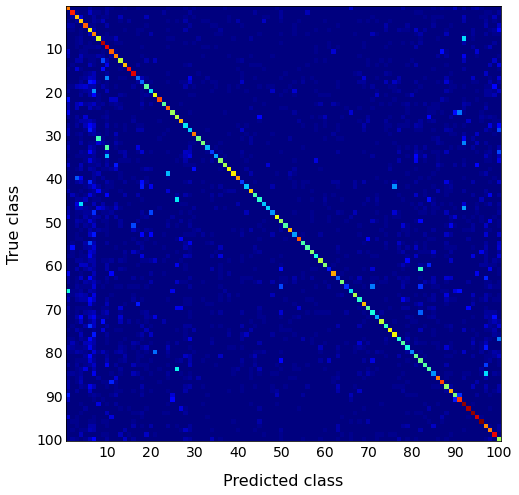

[80.0, 74.0, 71.0, 67.0, 61.0, 59.0, 56.0, 52.0, 49.0, 48.0]


In [ ]:
from matplotlib import ticker
import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False
np.random.seed(0)

numclass=10
feature_extractor=resnet18_cbam()
img_size=32
batch_size=128
task_size=10
memory_size=2000
epochs=70
learning_rate=2

model=iCaRLmodel(numclass,feature_extractor,batch_size,task_size,memory_size,epochs,learning_rate)
#model.model.load_state_dict(torch.load('model/ownTry_accuracy:84.000_KNN_accuracy:84.000_increment:10_net.pkl'))
acc = []
ac=[]
accu = 0
for i in range(10):
    model.beforeTrain()
    model.train()
    accuracy, current= model.afterTrain(accu)
    acc.append(accuracy)
    ac.append(current)

print(acc)
print(ac)

lastNet = model.getNet()
testLoader = model.getTestLoader()
confusion_matrix = get_conf_matrix(lastNet, testLoader, device)
display_conf_matrix(confusion_matrix, True)
print(acc)

In [ ]:
acctot = [int(el[0]) for el in acc ]
accurr = [int(el[1]) for el in acc ]
print(acctot)
print(accurr)
#FINET1
#[71, 41, 26, 21, 17, 13, 12, 10, 9, 8]
#[71, 83, 79, 84, 88, 83, 89, 86, 88, 85]
#[78, 41, 27, 21, 17, 14, 12, 10, 9, 9]
#[78, 82, 81, 84, 89, 89, 90, 87, 87, 91]
#[87, 43, 26, 20, 17, 14, 11, 11, 10, 8]
#[87, 87, 78, 83, 89, 87, 83, 90, 91, 85]

#LWF
#[79, 64, 56, 50, 45, 41, 38, 37, 36, 36]
#[79, 70, 67, 60, 64, 65, 56, 62, 61, 66]
#[86, 68, 59, 53, 48, 43, 42, 39, 38, 36]
#[86, 71, 70, 68, 58, 56, 63, 68, 59, 52
#[80, 64, 60, 53, 46, 43, 40, 40, 39, 37]
#[80, 72, 72, 59, 67, 60, 53, 69, 67, 47]

#[tensor(86), tensor(73), tensor(69), tensor(64), tensor(60), tensor(56), tensor(54), tensor(51), tensor(49), tensor(47)]'
#order
#[tensor(86), tensor(75), tensor(70), tensor(66), tensor(63), tensor(60), tensor(58), tensor(55), tensor(53), tensor(50)]]'
#rand1

TypeError: ignored

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
accuracy = np.array([88,76,74,69,62,58,56,54,52,50])
accuracy2 = np.array([85,73,71,65,60,56,53,52,49,46])
accuracy3 = accuracy2 - 2
classes = np.array([10,20,30,40,50,60,70,80,90,100])
data_preproc = pd.DataFrame({
    'Year':classes,
    'Ciao': accuracy,
    'Caoi': accuracy2,
    'Caio': accuracy3})
sns.set_style("whitegrid")
sns.despine(left=True)

sns.lineplot(x='Year', y='value', hue='variable',style="variable",
 markers=True, dashes=False, 
             data=pd.melt(data_preproc, ['Year']))